# 1. Summary 서울시 골목 상권 분석

● 본 프로젝트는 서울시 우리마을가게 상권분석에 게재되어있는 "우리마을가게 상권 데이터"들을 활용하여 서울시 45개 업종을 3가지 분류(외식업(10),도소매업(18),서비스업(17))를 통해 지역별,업종별로 어떠한 변수가 우선적으로 고려해야 할 사항인지 파악하고자 한다. 

● 더불어 이러한 EDA를 통해 얻은 주요요인들을 이용하여 LSTM , Decision Tree 모델을 이용하여 차 분기의 매출액을 예측하는 모델을 만들어 미래의 창업자들을 위해 수익성이 뛰어나는 입지를 추천하는 것이 최종적인 목표이다

### 사용할 모델 설명 

#### 변수간 상관관계 분석 : Linear Regression
#### 차분기 매출액 예측   : LSTM (Long Short Term Memory)

# 2. Data Description

사용데이터 - 서울시 우리마을가게 상권분석 (2016 Q1 ~ 2019 Q2) - 상권상주인구,상권영역,상권점포,상권아파트,상권추정유동인구,상권직장인구

#### 원본 데이터 : 분기, 서비스업종, 상권위치, 당월매출액(주중,주말,연령대별,요일별,시간대별로 분할), 점포수
#### 추가 데이터 : 구이름, 업종분류
#### 구이름 : "우리마을가게 상권영역" 데이터의 시군구코드를 이용하여 원데이터의 전체 데이터포인트를 서울시 25개 구로 변환
#### 업종분류 : 서비스업종 45개를 "외식업(10)" "도소매업(18)" "서비스업(17)"으로 대분류하여 변환
#### 데이터 결측치(NA)는 존재하지 않음

상업지에 거주하고 일하는 사람들의 소득수준과 주택규모 및 주택형태 2) 스타벅스의 개념에 적합한 주·야간의 인구규모 3) 상업지역 내의 기업체수 4) 경쟁자의 수와 매출규모 및 입지 5) 후보입지와 상권의 관련성 6) 점포 부근에서 실제 고객을 불러들이는 요소(population generator) 7) 거주자와 근로자, 쇼핑객과 단순 통행인의 통행패턴 8) 통행 패턴이 점포에 미칠 영향 등에 관한 것이다.

#### 기본 패키지 불러오기

In [1]:
#### 기본 패키치 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 중복출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
### 경고메시지 제거
import warnings
warnings.filterwarnings(action="ignore")

# 상권 매출액 16-1분기 ~ 19-2분기 데이터를 이용한 상권분석

# 데이터 전처리

#### 매출액 데이터 불러오기

In [303]:
sgrev16 = pd.read_csv("상권추정매출16.csv",encoding='euc-kr')
sgrev17 = pd.read_csv("상권추정매출17.csv",encoding='euc-kr')
sgrev18 = pd.read_csv("상권추정매출18.csv",encoding='euc-kr')
sgrev19 = pd.read_csv("상권추정매출19.csv",encoding='euc-kr')

In [304]:
dd = pd.read_csv("상권추정매출192.csv",encoding='euc-kr')

In [305]:
dd = dd[dd['기준_분기_코드']>=3]

In [306]:
sgrev19 = pd.concat([sgrev19,dd])

#### 추가 정보를 담은 데이터 불러오기

In [307]:
jg = pd.read_csv("상권집객시설.csv",encoding='euc-kr')                ## 집객시설
popul = pd.read_csv("상권상주인구.csv",encoding='euc-kr')             ## 상주인구
popul.rename(columns={"상권 코드" :"상권_코드"},inplace=True)
apart = pd.read_csv("상권아파트.csv",encoding='euc-kr')               ## 아파트
move = pd.read_csv("상권추정유동인구.csv",encoding='euc-kr')          ## 추정유동인구
move.rename(columns={"기준 년코드":"기준_년_코드"},inplace=True)
job = pd.read_csv("상권직장인구.csv",encoding='euc-kr')               ## 직장인구
job.rename(columns={"기준_년월_코드":"기준_년_코드"},inplace=True)

## 유동인구, 집객시설 19_3,4 분기 merge

In [308]:
my1 = pd.read_csv("유동인구19.csv",encoding='euc-kr')
my2 = pd.read_csv("집객시설19.csv",encoding='euc-kr')

In [309]:
move34 = my1[my1['기준_분기_코드']>=3]
jg34 = my2[my2['기준_분기_코드']>=3]

In [310]:
move34.rename(columns={'기준 년코드':'기준_년_코드'},inplace=True)

In [311]:
move = pd.concat([move,move34])

In [312]:
jg = pd.concat([jg,jg34])

In [313]:
jg= jg[['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '집객시설_수','지하철_역_수', '버스_정거장_수']]

In [314]:
move = move[['기준_년_코드', '기준_분기_코드', ' 상권_구분_코드', ' 상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수',
       '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
       '시간대_1_유동인구_수', '시간대_2_유동인구_수', '시간대_3_유동인구_수', '시간대_4_유동인구_수',
       '시간대_5_유동인구_수', '시간대_6_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수']]

#### 변수명 표준화 - 모든 데이터의 변수명 동일화

In [315]:
len(sgrev16.columns)
len(sgrev19.columns)

80

80

In [316]:
for i in range(0,80):
    sgrev16.rename(columns = {sgrev16.columns[i] : sgrev19.columns[i]},inplace=True)

In [317]:
for i in range(0,80):
    sgrev17.rename(columns = {sgrev17.columns[i] : sgrev19.columns[i]},inplace=True)

#### 상권영역 데이터는 해당 상권이 속한 지역구를 알 수 있으므로 merge를 위해 사용

In [318]:
sgregion = pd.read_csv("상권영역.csv", encoding='euc-kr')

In [319]:
sgregion

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보
0,201810,R,전통시장,1001453,낙성대시장,196121,442084,11620,11620585,NaN
1,201810,R,전통시장,1001454,봉천제일종합시장,195147,442413,11620,11620595,NaN
2,201810,R,전통시장,1001474,도곡시장,204551,444227,11680,11680650,NaN
3,201810,R,전통시장,1001475,강남개포시장,206065,443310,11680,11680670,NaN
4,201810,R,전통시장,1001412,화곡본동시장,186203,449328,11500,11500590,NaN
...,...,...,...,...,...,...,...,...,...,...
1491,201810,D,발달상권,1001044,양재역_3,202755,443008,11650,11650520,NaN
1492,201810,D,발달상권,1001030,양재역_2,203216,442691,11650,11650651,NaN
1493,201810,D,발달상권,1001031,서울 관악구 신림역_1,193706,442615,11620,11620645,NaN
1494,201810,D,발달상권,1001032,서울 관악구 신림역_2,193880,442602,11620,11620645,NaN


- 상권추정 매출액 데이터 병합 (16_1 ~ 19_2 분기)

In [320]:
sgrev = pd.concat([sgrev16,sgrev17,sgrev18,sgrev19])

- 지역구 파악을 위한 시군구_코드 추출

In [321]:
code = sgregion[["상권_코드","시군구_코드","행정동_코드","엑스좌표_값","와이좌표_값"]]

#### 시군구코드, 행정동코드 불러온 후 상권추정매출 데이터와 병합

In [322]:
sgdata = pd.merge(sgrev,code)

-  시군구코드에 맞는 시군구이름 데이터 생성

In [323]:
gu =pd.DataFrame([[11110 ,'종로구'],[11140 ,'중구'],[11170 ,'용산구'],[11200 ,'성동구'],[11215 ,'광진구'],
              [11230 ,'동대문구'],[11260 ,'중랑구'],[11290 ,'성북구'],[11305 ,'강북구'],[11320 ,'도봉구'],
              [11350 ,'노원구'],[11380 ,'은평구'],[11410 ,'서대문구'],[11440 ,'마포구'],[11470 ,'양천구'],
              [11500 ,'강서구'],[11530 ,'구로구'],[11545 ,'금천구'],[11560 ,'영등포구'],[11590 ,'동작구'],
              [11620 ,'관악구'],[11650 ,'서초구'],[11680 ,'강남구'],[11710 ,'송파구'],[11740 ,'강동구']],
             columns=["시군구_코드","시군구명"])

In [324]:
sgdata.isnull().sum()

기준_년_코드       0
기준_분기_코드      0
상권_구분_코드      0
상권_구분_코드_명    0
상권_코드         0
             ..
점포수           0
시군구_코드        0
행정동_코드        0
엑스좌표_값        0
와이좌표_값        0
Length: 84, dtype: int64

#### 업종별 분석을 위해 외식업,도소매업,서비스업을 다음과 같이 분류

In [325]:
외식업 =pd.DataFrame({"서비스_업종_코드_명" :
                   ["분식전문점","양식음식점","일식음식점","제과점","커피·음료","중식음식점",
                    "한식음식점","패스트푸드점","호프·간이주점","치킨전문점"] })


도소매업 = pd.DataFrame({"서비스_업종_코드_명":
                     ["가구·가전","가전제품수리","건강보조식품","섬유제품","서적·문구","식료품","의류점","의약·의료용품","슈퍼마켓",
                      "주방·가정용품","컴퓨터·주변기기","통신판매업","패션용품","핸드폰","화장품","화초·애완","편의점"]})

서비스업 = pd.DataFrame({"서비스_업종_코드_명" :
                     ["PC방","네일숍","노래방","당구장","두발미용업","부동산중개업","세탁소(가정)","숙박업","스포츠클럽","자동차수리·세차",
                      "예체능학원","오락·운동","외국어학원","일반교습학원","일반의원","치과의원","피부관리실","한의원"]})

외식업["업종분류"] = "외식업"
도소매업["업종분류"] = "도소매업"
서비스업["업종분류"] = "서비스업"
업종 = pd.concat([외식업,도소매업,서비스업],ignore_index = True)

#### 최종적으로 지역구이름과 업종분류를 원데이터에 병합

In [326]:
sgdata = pd.merge(sgdata,gu) ## 구 이름 병합
sgdata = pd.merge(sgdata,업종) ## 업종분류 병합

### 추가 변수 병합

In [327]:
data = jg[['기준_년_코드', '기준_분기_코드',  '상권_코드', '집객시설_수','지하철_역_수', '버스_정거장_수']]

data1 = popul[['기준_년_코드', '기준_분기_코드', '상권_코드','총 상주인구 수', '남성 상주인구 수', '여성 상주인구 수', '연령대 10 상주인구 수', '연령대 20 상주인구 수',
       '연령대 30 상주인구 수', '연령대 40 상주인구 수', '연령대 50 상주인구 수', '연령대 60 이상 상주인구 수']]

data2 = apart[["기준_년_코드","기준_분기_코드","상권_코드","아파트_단지_수","아파트_평균_면적","아파트_평균_시가"]]

data3 = move[['기준_년_코드', '기준_분기_코드', '상권_코드',
       '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수',
       '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
       '시간대_1_유동인구_수', '시간대_2_유동인구_수', '시간대_3_유동인구_수', '시간대_4_유동인구_수',
       '시간대_5_유동인구_수', '시간대_6_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수']]

data4 = job[["기준_년_코드","기준_분기_코드","상권_코드",'총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '연령대_10_직장_인구_수',
       '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수',
       '연령대_60_이상_직장_인구_수']]

In [328]:
data = data[data['상권_코드']<=1001010]
data1 = data1[data1['상권_코드']<=1001010]
data2 = data2[data2['상권_코드']<=1001010]
data3 = data3[data3['상권_코드']<=1001010]
data4 = data4[data4['상권_코드']<=1001010]

In [329]:
sgdata = sgdata[sgdata['상권_구분_코드_명']=='골목상권']

In [332]:
year = sgdata['기준_년_코드'].unique().tolist()
quarter = sgdata['기준_분기_코드'].unique().tolist()

In [334]:
for i in year:
    for j in quarter:
        df = sgdata[sgdata['기준_년_코드']==i][sgdata['기준_분기_코드']==j]
        print(i,"-",j,"  row",len(df['상권_코드'].unique().tolist()))

2016 - 1   row 1010
2016 - 2   row 1010
2016 - 3   row 1010
2016 - 4   row 1010
2017 - 1   row 1010
2017 - 2   row 1010
2017 - 3   row 1010
2017 - 4   row 1010
2018 - 1   row 1010
2018 - 2   row 1010
2018 - 3   row 1010
2018 - 4   row 1010
2019 - 1   row 1010
2019 - 2   row 1009
2019 - 3   row 1006
2019 - 4   row 1008


In [335]:
sgdata = pd.merge(sgdata,data,how='left')
sgdata =pd.merge(sgdata,data1,how='left')
sgdata = pd.merge(sgdata,data2,how='left')
sgdata = pd.merge(sgdata,data3,how='left')
sgdata = pd.merge(sgdata,data4,how='left')

In [336]:
sgdata.isnull().sum()

기준_년_코드                 0
기준_분기_코드                0
상권_구분_코드                0
상권_구분_코드_명              0
상권_코드                   0
                     ... 
연령대_20_직장_인구_수       9629
연령대_30_직장_인구_수       9629
연령대_40_직장_인구_수       9629
연령대_50_직장_인구_수       9629
연령대_60_이상_직장_인구_수    9629
Length: 132, dtype: int64

In [337]:
sgdata.fillna(0,inplace=True)

In [339]:
sgdata.isnull().sum()
sgdata.columns

기준_년_코드              0
기준_분기_코드             0
상권_구분_코드             0
상권_구분_코드_명           0
상권_코드                0
                    ..
연령대_20_직장_인구_수       0
연령대_30_직장_인구_수       0
연령대_40_직장_인구_수       0
연령대_50_직장_인구_수       0
연령대_60_이상_직장_인구_수    0
Length: 132, dtype: int64

Index(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '서비스_업종_코드', '서비스_업종_코드_명', '당월_매출_금액', '당월_매출_건수',
       ...
       '일요일_유동인구_수', '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '연령대_10_직장_인구_수',
       '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수',
       '연령대_60_이상_직장_인구_수'],
      dtype='object', length=132)

#### 결측치가 존재하는 컬럼은 각각 독립적으로 해당하는 구의 평균치로 대체

In [219]:
fill_mean_func = lambda g: g.fillna(g.mean())

In [220]:
sgdata = sgdata.groupby('시군구명').apply(fill_mean_func)
sgdata.reset_index(drop=True,inplace=True)

#### 1차 전처리 데이터완성

In [221]:
sgdata.to_csv("전처리상권데이터.csv",encoding='euc-kr')

#### 업종별 점포수를 sum하기 위한 전처리 - 매출액 데이터보다 자세하게 나와있는 상권점포 데이터를 이용하여 갱신하였음

In [343]:
jumpo = pd.read_csv("상권점포.csv",encoding='euc-kr')

In [344]:
도소매업 = pd.DataFrame({"서비스_업종_코드_명":
                     (["가구","가구?가전","가방","가전제품","가전제품수리","가정용품임대","건강보조식품","모터사이클및부품","모터사이클수리",
                      "문구","미곡판매","미용재료","반찬가게","섬유제품","서적","서적?문구","수산물판매","식료품",
                      "시계및귀금속","신발","악기","안경","의약·의료용품","슈퍼마켓","예술품","완구","운동/경기용품","유아의류",
                      "육류판매","의류기기","의류점","의약?의료용품","의약품","일반의류","자동차부품","자전거 및 기타운송장비","재생용품 판매점",
                      "전자상거래업","조명용품","주류도매","주방?가정용품","중고가구","중고차판매","철물점","청과상","컴퓨터?주변기기","컴퓨터및주변장치판매",
                      "통신판매업","패션용품","한복점","편의점","핸드폰","화장품","화초","화초?애완"])})

서비스업 = pd.DataFrame({"서비스_업종_코드_명" :
                     (["DVD방","PC방","건축물청소","게스트하우스","고시원","골프연습장","기타법무서비스","기타오락장","네일숍","노래방",
                      "녹음실","독서실","당구장","동물병원","미용실","두발미용업","법무사사무소","변리사사무소","변호사사무소","복권방",
                      "볼링장","부동산중개업","비디오/서적임대","사진관","세무사사무소","세탁소","세탁소(가정)","숙박업","스포츠 강습",
                      "스포츠클럽","애완동물","자동차수리·세차","여관","여행사","예술학원","예체능학원","오락?운동","외국어학원","의류임대",
                      "인테리어","일반교습학원","일반의원","자동차미용","자동차수리?세차","전자게임장","주유소","치과의원","컴퓨터학원","통번역서비스",
                      "피부관리실","한의원","회계사사무소","통신기기수리"])})


외식업 =pd.DataFrame({"서비스_업종_코드_명" :
                   ["분식전문점","양식음식점","일식음식점","제과점","커피-음료",'커피?음료',"중식음식점",
                    "한식음식점","패스트푸드점","호프-간이주점","호프?간이주점","치킨전문점"] })



외식업["업종분류"] = "외식업"
도소매업["업종분류"] = "도소매업"
서비스업["업종분류"] = "서비스업"
업종 = pd.concat([외식업,도소매업,서비스업],ignore_index = True)

#### 골목상권에 대해서만 분석하고자 함 (발달상권,전통시장,관광특구 제외)

In [345]:
jumpo = jumpo[jumpo["상권_구분_코드_명"]=="골목상권"]

In [346]:
jumpo = pd.merge(jumpo,업종)

#### 연도별 분기별 상권별 업종분류별 점포수를 SUM하기 위해 피벗테이블 만든 후 reset_index()를 통해 분리

In [359]:
jum = jumpo[jumpo['업종분류']=='외식업']

In [361]:
idx = jum.loc[jum['서비스_업종_코드_명'].str.contains('커피')].index

for i in idx:
    jum['서비스_업종_코드_명'][i] = '커피·음료'

In [362]:
idx = jum.loc[jum['서비스_업종_코드_명'].str.contains('호프')].index

for i in idx:
    jum['서비스_업종_코드_명'][i] = '호프·간이주점'

In [242]:
jumpo[jumpo['업종분류']=='외식업']['서비스_업종_코드_명'].unique().tolist()

['커피-음료',
 '호프-간이주점',
 '분식전문점',
 '치킨전문점',
 '패스트푸드점',
 '일식음식점',
 '중식음식점',
 '한식음식점',
 '제과점',
 '양식음식점',
 '호프?간이주점',
 '커피?음료']

In [256]:
data[data['업종분류']=='외식업']['서비스_업종_코드_명'].unique().tolist()

['커피·음료',
 '호프·간이주점',
 '치킨전문점',
 '한식음식점',
 '중식음식점',
 '일식음식점',
 '양식음식점',
 '분식전문점',
 '패스트푸드점',
 '제과점']

In [363]:
jum[jum['업종분류']=='외식업']['서비스_업종_코드_명'].unique().tolist()

['커피·음료',
 '호프·간이주점',
 '분식전문점',
 '치킨전문점',
 '패스트푸드점',
 '일식음식점',
 '중식음식점',
 '한식음식점',
 '제과점',
 '양식음식점']

In [364]:
jum[jum['서비스_업종_코드_명']=='한식음식점']['상권_코드'].unique().tolist()

[1001010,
 1001009,
 1001008,
 1001007,
 1001006,
 1001005,
 1001004,
 1001003,
 1001002,
 1001001,
 1001000,
 1000999,
 1000998,
 1000997,
 1000996,
 1000995,
 1000994,
 1000993,
 1000992,
 1000991,
 1000990,
 1000989,
 1000988,
 1000987,
 1000986,
 1000985,
 1000984,
 1000983,
 1000982,
 1000981,
 1000980,
 1000979,
 1000978,
 1000977,
 1000976,
 1000975,
 1000974,
 1000973,
 1000972,
 1000971,
 1000970,
 1000969,
 1000968,
 1000967,
 1000966,
 1000965,
 1000964,
 1000963,
 1000962,
 1000961,
 1000960,
 1000959,
 1000958,
 1000957,
 1000956,
 1000955,
 1000954,
 1000953,
 1000952,
 1000951,
 1000950,
 1000949,
 1000948,
 1000947,
 1000946,
 1000945,
 1000944,
 1000943,
 1000942,
 1000941,
 1000940,
 1000939,
 1000938,
 1000937,
 1000936,
 1000935,
 1000934,
 1000933,
 1000932,
 1000931,
 1000930,
 1000929,
 1000928,
 1000927,
 1000926,
 1000925,
 1000924,
 1000923,
 1000922,
 1000921,
 1000920,
 1000919,
 1000918,
 1000917,
 1000916,
 1000915,
 1000914,
 1000913,
 1000912,
 1000911,


In [365]:
jumpo2 = pd.pivot_table(jum,index=["기준_년_코드","기준_분기_코드","상권_코드","서비스_업종_코드_명"],values="점포_수",aggfunc='sum').reset_index()

In [366]:
jumpo2[jumpo2['서비스_업종_코드_명']=='한식음식점']['상권_코드'].unique().tolist()

[1000001,
 1000002,
 1000003,
 1000004,
 1000005,
 1000006,
 1000007,
 1000008,
 1000009,
 1000010,
 1000011,
 1000012,
 1000013,
 1000014,
 1000015,
 1000016,
 1000017,
 1000018,
 1000019,
 1000020,
 1000021,
 1000022,
 1000023,
 1000024,
 1000025,
 1000026,
 1000027,
 1000028,
 1000029,
 1000030,
 1000031,
 1000032,
 1000033,
 1000034,
 1000035,
 1000036,
 1000037,
 1000038,
 1000039,
 1000040,
 1000041,
 1000042,
 1000043,
 1000044,
 1000045,
 1000046,
 1000047,
 1000048,
 1000049,
 1000050,
 1000051,
 1000052,
 1000053,
 1000054,
 1000055,
 1000056,
 1000057,
 1000058,
 1000059,
 1000060,
 1000061,
 1000062,
 1000063,
 1000064,
 1000065,
 1000066,
 1000067,
 1000068,
 1000069,
 1000070,
 1000071,
 1000072,
 1000073,
 1000074,
 1000075,
 1000076,
 1000077,
 1000078,
 1000079,
 1000080,
 1000081,
 1000082,
 1000083,
 1000084,
 1000085,
 1000086,
 1000087,
 1000088,
 1000089,
 1000090,
 1000091,
 1000092,
 1000093,
 1000094,
 1000095,
 1000096,
 1000097,
 1000098,
 1000099,
 1000100,


### 지역별 외식업,도소매업,서비스업 분류에 따른 변수 중요도 파악을 위한 최종 데이터

In [368]:
data = pd.read_csv("전처리상권데이터.csv",encoding='euc-kr')

#### 위에서 만든 데이터 -이것을 쓴 이유는 상권추정매출에있는 점포수보다 더 자세하게나와있음

- 1차 전처리 데이터에서 비율,요일별, 자세하지않은 점포 수에 관한 컬럼은 제거

In [277]:
df = data.drop(columns=['Unnamed: 0','서비스_업종_코드','서비스_업종_코드_명','주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율',
       '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율','월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액','월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수','점포수'])

- 연도별 분기별 상권코드별 업종분류별 시군구명으로 보기 위해 피벗데이터프레임 생성
- 새로운 점포수 데이터(jumpo2)와 병합을 함
- Inf, NaN 값을 모두 제거 및 확인 후 최종데이터 final 생서
- final 데이터를 통해 성장상권 분류시각화 및 변수 중요도 파악 진행

In [230]:
mypivot =pd.pivot_table(data,index=['기준_년_코드','기준_분기_코드','상권_코드','업종분류','시군구명'],values=df.columns.difference(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명','시군구_코드',
       '행정동_코드', '엑스좌표_값', '와이좌표_값', '시군구명', '업종분류']),aggfunc='sum').reset_index()

In [373]:
data = data.sort_values(by=['기준_년_코드','기준_분기_코드'])

In [374]:
data=data[data['업종분류']=='외식업']

In [377]:
data

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,...,일요일_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,연령대_30_직장_인구_수,연령대_40_직장_인구_수,연령대_50_직장_인구_수,연령대_60_이상_직장_인구_수
0,0,2016,1,A,골목상권,1000886,강남대로118길,CS100001,한식음식점,274235332,...,13035,564.0,316.0,248.0,2.0,84.0,161.0,114.0,85.0,118.0
18,18,2016,1,A,골목상권,1000887,강남대로136길,CS100001,한식음식점,151244188,...,5020,1187.0,667.0,520.0,2.0,259.0,458.0,274.0,111.0,83.0
36,36,2016,1,A,골목상권,1000888,강남대로140길,CS100001,한식음식점,297229131,...,10159,4530.0,2545.0,1985.0,22.0,926.0,1350.0,928.0,873.0,431.0
54,54,2016,1,A,골목상권,1000889,개포로17길,CS100001,한식음식점,518518549,...,12190,2694.0,1749.0,945.0,8.0,402.0,825.0,755.0,505.0,199.0
72,72,2016,1,A,골목상권,1000890,개포로20길,CS100001,한식음식점,1477476845,...,12891,4197.0,2384.0,1813.0,24.0,696.0,1035.0,1165.0,808.0,469.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366981,366981,2019,4,A,골목상권,1000256,용마산로100길,CS100007,치킨전문점,103938725,...,107591,122.0,52.0,70.0,0.0,31.0,16.0,29.0,29.0,17.0
366999,366999,2019,4,A,골목상권,1000257,용마산로112길,CS100007,치킨전문점,88507937,...,161208,114.0,69.0,45.0,0.0,14.0,22.0,23.0,29.0,26.0
367017,367017,2019,4,A,골목상권,1000258,용마산로118길,CS100007,치킨전문점,40809165,...,110522,108.0,63.0,45.0,1.0,11.0,17.0,28.0,30.0,21.0
367023,367023,2019,4,A,골목상권,1000259,용마산로94길,CS100007,치킨전문점,4831581,...,61493,304.0,259.0,45.0,0.0,11.0,41.0,65.0,94.0,93.0


In [376]:
jumpo2

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,점포_수
0,2014,1,1000001,분식전문점,3
1,2014,1,1000001,양식음식점,7
2,2014,1,1000001,일식음식점,2
3,2014,1,1000001,제과점,1
4,2014,1,1000001,중식음식점,2
...,...,...,...,...,...
224526,2019,4,1001010,치킨전문점,0
224527,2019,4,1001010,커피·음료,3
224528,2019,4,1001010,패스트푸드점,0
224529,2019,4,1001010,한식음식점,11


In [380]:
final =pd.merge(data,jumpo2,how='left')

In [385]:
final.fillna(0,inplace=True)

In [386]:
del final['Unnamed: 0']

- Nan, Inf값 모두 없음을 확인

In [388]:
final.to_csv("final.csv",encoding='euc-kr')

-------------------------------------------------------------------------------------

# 분석

In [2]:
final = pd.read_csv("final.csv",encoding='euc-kr')

In [10]:
final
final.columns

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_코드,업종분류,시군구명,남성 상주인구 수,남성_매출_건수,남성_매출_금액,남성_유동인구_수,...,주말_매출_건수,주말_매출_금액,주중_매출_건수,주중_매출_금액,집객시설_수,총 상주인구 수,총_유동인구_수,총_직장_인구_수,점포_수,점포당_매출액
0,0,2016,1,1000001,도소매업,종로구,5656.0,74706,672779988,374296.0,...,38918,530839851,100377,1176040734,288.0,12208.0,614584.0,7080.000000,53,3.220529e+07
1,1,2016,1,1000001,서비스업,종로구,4242.0,1039,68721150,280722.0,...,755,84115633,1967,143313577,216.0,9156.0,460938.0,5310.000000,30,7.580974e+06
2,2,2016,1,1000001,외식업,종로구,5656.0,66835,1054248401,374296.0,...,37425,736961381,118716,1910417247,288.0,12208.0,614584.0,7080.000000,46,5.755171e+07
3,3,2016,1,1000002,도소매업,종로구,4851.0,80493,1574882864,844767.0,...,51034,1149720978,112684,2586196029,18.0,9450.0,1431378.0,5215.933496,67,5.575996e+07
4,4,2016,1,1000002,서비스업,종로구,2695.0,2292,129197408,469315.0,...,1186,61826544,2814,238971641,10.0,5250.0,795210.0,2897.740831,22,1.367264e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42330,42330,2019,2,1001009,서비스업,강동구,16448.0,7113,382447662,2952576.0,...,1993,123579916,11346,697609604,72.0,32256.0,5906048.0,4344.000000,62,1.324499e+07
42331,42331,2019,2,1001009,외식업,강동구,12336.0,13600,274269701,2214432.0,...,6517,135130408,18010,357723574,54.0,24192.0,4429536.0,3258.000000,40,1.232135e+07
42332,42332,2019,2,1001010,도소매업,강동구,15260.0,98538,1276849307,857090.0,...,29501,288855357,144617,2016406899,100.0,30880.0,1803280.0,2310.000000,41,5.622591e+07
42333,42333,2019,2,1001010,서비스업,강동구,6104.0,835,83043031,342836.0,...,376,30589816,1439,205820732,40.0,12352.0,721312.0,924.000000,57,4.147553e+06


Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '상권_코드', '업종분류', '시군구명',
       '남성 상주인구 수', '남성_매출_건수', '남성_매출_금액', '남성_유동인구_수', '남성_직장_인구_수',
       '당월_매출_건수', '당월_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액',
       '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액',
       '시간대_21~24_매출_금액', '시간대_건수~06_매출_건수', '시간대_건수~11_매출_건수',
       '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수',
       '시간대_건수~24_매출_건수', '아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가', '여성 상주인구 수',
       '여성_매출_건수', '여성_매출_금액', '여성_유동인구_수', '여성_직장_인구_수', '연령대_10_매출_건수',
       '연령대_10_매출_금액', '연령대_20_매출_건수', '연령대_20_매출_금액', '연령대_30_매출_건수',
       '연령대_30_매출_금액', '연령대_40_매출_건수', '연령대_40_매출_금액', '연령대_50_매출_건수',
       '연령대_50_매출_금액', '연령대_60_이상_매출_건수', '연령대_60_이상_매출_금액', '주말_매출_건수',
       '주말_매출_금액', '주중_매출_건수', '주중_매출_금액', '집객시설_수', '총 상주인구 수', '총_유동인구_수',
       '총_직장_인구_수', '점포_수', '점포당_매출액'],
      dtype='object')

#### 상반기,하반기로 분류  - 분석에 사용하지 않았음

In [4]:
상반기 =pd.DataFrame({"기준_년_코드" : [2016,2016,2016,2016,2017,2017,2017,2017,2018,2018,2018,2018,2019,2019],
                      "기준_분기_코드":[1,2,3,4,1,2,3,4,1,2,3,4,1,2],
                      "상하" :["상반기","상반기","하반기","하반기","상반기","상반기","하반기","하반기","상반기","상반기","하반기","하반기","상반기","상반기"]   })

del final["Unnamed: 0"]
final =pd.merge(final,상반기)

#### 스케일링 모듈 불러오기

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

In [473]:
#norm = Normalizer()
#norm.fit(cluster)
#x_scaled = norm.transform(cluster)

#std = StandardScaler()
#std.fit(cluster)
#x_scaled = std.transform(cluster)

#rbs = RobustScaler()
#rbs.fit(cluster)
#x_scaled = rbs.transform(cluster)

#scl = MinMaxScaler()
#scl.fit(cluster)
#x_scaled = scl.transform(cluster)

#### 지역구 확인

In [47]:
np.unique(data["시군구명"])

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

#### 지역구-업종별 성장도 (상,중,하) 분류 시각화 
- 성장도(상) = 빨강
- 성장도(중) = 파랑
- 성장도(하) = 검정

In [527]:
num=np.unique(final[final["시군구명"]=="관악구"]["상권_코드"])
st = ["16_1","16_2","16_3","16_4",
      "17_1","17_2","17_3","17_4",
      "18_1","18_2","18_3","18_4",
      "19_1","19_2"]

# 도소매업
sg = final[final["상권_코드"]==num[0]][final["업종분류"]=="도소매업"]
sales = []
for i in range(0,len(sg)):
    sales.append((sg.iloc[i,11]))
    
df1 = pd.DataFrame(np.array(sales)).T
df1.insert(0,"상권_코드",value=num[0])

for i in range(num[1],num[len(num)-1]):
    sg = final[final["상권_코드"]==i][final["업종분류"]=="도소매업"]
    sales = []
    for j in range(0,len(sg)):
        sales.append((sg.iloc[j,11]))
    b = pd.DataFrame(np.array(sales)).T
    b.insert(0,"상권_코드",value=i)
    df1 = pd.concat([df1,b])
    
for i in range(1,len(st)+1):
    df1.rename(columns = {df1.columns[i] : st[i-1]},inplace=True)

# 서비스업
sg = final[final["상권_코드"]==num[0]][final["업종분류"]=="서비스업"]
sales = []
for i in range(0,len(sg)):
    sales.append((sg.iloc[i,11]))
    
df2 = pd.DataFrame(np.array(sales)).T
df2.insert(0,"상권_코드",value=num[0])

for i in range(num[1],num[len(num)-1]):
    sg = final[final["상권_코드"]==i][final["업종분류"]=="서비스업"]
    sales = []
    for j in range(0,len(sg)):
        sales.append((sg.iloc[j,11]))
    b = pd.DataFrame(np.array(sales)).T
    b.insert(0,"상권_코드",value=i)
    df2 = pd.concat([df2,b])

for i in range(1,len(st)+1):
    df2.rename(columns = {df2.columns[i] : st[i-1]},inplace=True)

# 외식업
sg = final[final["상권_코드"]==num[0]][final["업종분류"]=="외식업"]
sales = []
for i in range(0,len(sg)):
    sales.append((sg.iloc[i,11]))
    
df3 = pd.DataFrame(np.array(sales)).T
df3.insert(0,"상권_코드",value=num[0])

for i in range(num[1],num[len(num)-1]):
    sg = final[final["상권_코드"]==i][final["업종분류"]=="외식업"]
    sales = []
    for j in range(0,len(sg)):
        sales.append((sg.iloc[j,11]))
    b = pd.DataFrame(np.array(sales)).T
    b.insert(0,"상권_코드",value=i)
    df3 = pd.concat([df3,b])

for i in range(1,len(st)+1):
    df3.rename(columns = {df3.columns[i] : st[i-1]},inplace=True)

###
df1.dropna(inplace=True)
df2.dropna(inplace=True)    
df3.dropna(inplace=True)

del df1["19_1"]
del df1["19_2"]
del df2["19_1"]
del df2["19_2"]
del df3["19_1"]
del df3["19_2"]

In [528]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

In [529]:
for i in range(0,len(df1)):
    df1.iloc[i,1:] = norm(df1.iloc[i,1:])

for i in range(0,len(df2)):
    df2.iloc[i,1:] = norm(df2.iloc[i,1:])

for i in range(0,len(df3)):
    df3.iloc[i,1:] = norm(df3.iloc[i,1:])
    
model = KMeans(n_clusters = 3,random_state = 97)
cluster1 = df1.iloc[:,1:]
cluster2 = df2.iloc[:,1:]
cluster3 = df3.iloc[:,1:]

1    24
0    22
2    16
Name: cluster, dtype: int64

0    25
1    19
2    18
Name: cluster, dtype: int64

1    25
2    19
0    18
Name: cluster, dtype: int64

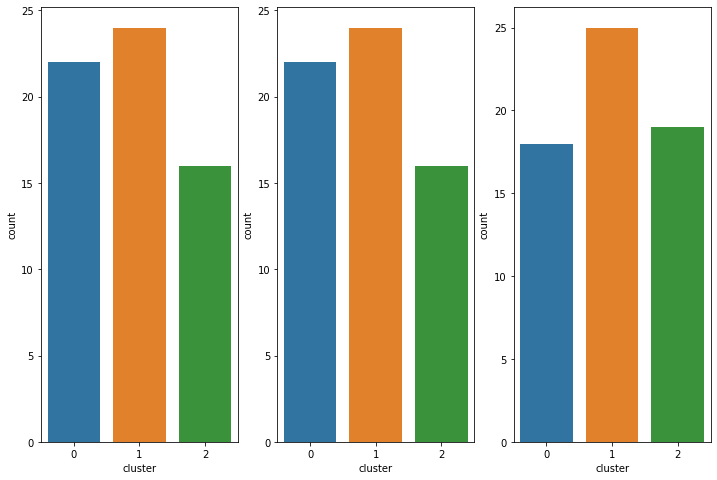

In [530]:
group = model.fit_predict(cluster1)
df1["cluster"]=group
plt.rcParams['figure.figsize'] = [12, 8]
plt.subplot(1,3,1)
sns.countplot(x= "cluster",data=df1)
df1["cluster"].value_counts()


group = model.fit_predict(cluster2)
df2["cluster"]=group
plt.rcParams['figure.figsize'] = [12, 8]
plt.subplot(1,3,2)
sns.countplot(x= "cluster",data=df1)
df2["cluster"].value_counts()

group = model.fit_predict(cluster3)
df3["cluster"]=group
plt.rcParams['figure.figsize'] = [12, 8]
plt.subplot(1,3,3)
sns.countplot(x= "cluster",data=df3)
df3["cluster"].value_counts()

Text(0.5, 1.0, 'Whole and Retail')

Text(0, 0.5, 'Sales Scaling')

Text(0.5, 0, 'Quarter')

Text(0.5, 1.0, 'Service')

Text(0, 0.5, 'Sales Scaling')

Text(0.5, 0, 'Quarter')

Text(0.5, 1.0, 'Restaurant')

Text(0, 0.5, 'Sales Scaling')

Text(0.5, 0, 'Quarter')

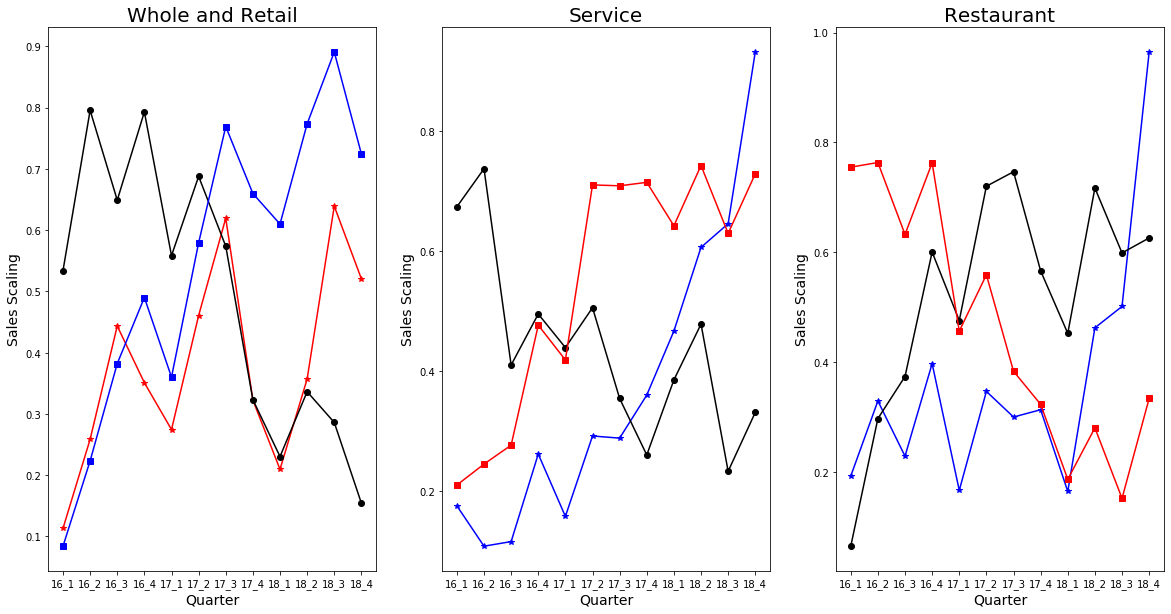

In [531]:
g0 = df1[df1["cluster"]==0].mean()
g1 = df1[df1["cluster"]==1].mean()
g2 = df1[df1["cluster"]==2].mean()

g0df = pd.DataFrame(g0,columns=["Group 0"])
g1df = pd.DataFrame(g1,columns=["Group 1"])
g2df = pd.DataFrame(g2,columns=["Group 2"])
gdf1 = pd.concat([g0df,g1df,g2df],axis=1)
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,3,1)

plt.plot(gdf1.index[1:13],gdf1.iloc[1:13].values[:,0], marker='*', color='red')
plt.plot(gdf1.index[1:13],gdf1.iloc[1:13].values[:,1], marker='o', color='black')
plt.plot(gdf1.index[1:13],gdf1.iloc[1:13].values[:,2], marker='s', color='blue')
plt.title('Whole and Retail', fontsize=20) 
plt.ylabel('Sales Scaling', fontsize=14)
plt.xlabel('Quarter', fontsize=14)
#####

g0 = df2[df2["cluster"]==0].mean()
g1 = df2[df2["cluster"]==1].mean()
g2 = df2[df2["cluster"]==2].mean()

g0df = pd.DataFrame(g0,columns=["Group 1"])
g1df = pd.DataFrame(g1,columns=["Group 2"])
g2df = pd.DataFrame(g2,columns=["Group 3"])
gdf2 = pd.concat([g0df,g1df,g2df],axis=1)

plt.subplot(1,3,2)
plt.plot(gdf2.index[1:13],gdf2.iloc[1:13].values[:,0], marker='*', color='blue')
plt.plot(gdf2.index[1:13],gdf2.iloc[1:13].values[:,1], marker='o', color='black')
plt.plot(gdf2.index[1:13],gdf2.iloc[1:13].values[:,2], marker='s', color='red')
plt.title('Service', fontsize=20) 
plt.ylabel('Sales Scaling', fontsize=14)
plt.xlabel('Quarter', fontsize=14)

plt.subplot(1,3,3)
g0 = df3[df3["cluster"]==0].mean()
g1 = df3[df3["cluster"]==1].mean()
g2 = df3[df3["cluster"]==2].mean()

g0df = pd.DataFrame(g0,columns=["Group 0"])
g1df = pd.DataFrame(g1,columns=["Group 1"])
g2df = pd.DataFrame(g2,columns=["Group 2"])
gdf3 = pd.concat([g0df,g1df,g2df],axis=1)
plt.plot(gdf3.index[1:13],gdf3.iloc[1:13].values[:,0], marker='*', color='blue')
plt.plot(gdf3.index[1:13],gdf3.iloc[1:13].values[:,1], marker='o', color='black')
plt.plot(gdf3.index[1:13],gdf3.iloc[1:13].values[:,2], marker='s', color='red')
plt.title('Restaurant', fontsize=20) 
plt.ylabel('Sales Scaling', fontsize=14)
plt.xlabel('Quarter', fontsize=14)
    

### 성장도 (상) 상권지역 추출

In [452]:
whole=df1[df1["cluster"]==0]["상권_코드"].values
service = df2[df2["cluster"]==2]["상권_코드"].values
rest = df3[df3["cluster"]==2]["상권_코드"].values
whole
service
rest


array([1000459, 1000463, 1000469, 1000471, 1000475, 1000476, 1000478,
       1000481, 1000482, 1000484, 1000485, 1000487, 1000491, 1000492,
       1000493, 1000497, 1000499, 1000502, 1000503, 1000504], dtype=int64)

array([1000463, 1000465, 1000467, 1000470, 1000471, 1000472, 1000474,
       1000478, 1000479, 1000480, 1000481, 1000484, 1000494, 1000501,
       1000502], dtype=int64)

array([1000460, 1000461, 1000462, 1000467, 1000471, 1000473, 1000477,
       1000481, 1000486, 1000487, 1000488, 1000491, 1000492, 1000495,
       1000501, 1000502, 1000504, 1000505], dtype=int64)

---------------------------------------------------

### 지역구 성장상권 to.csv

In [453]:
도소매업 =whole
도소매업 = pd.DataFrame(도소매업,columns=["도소매업"])

서비스업 =service
서비스업 = pd.DataFrame(서비스업,columns=["서비스업"])

외식업 = rest
외식업 = pd.DataFrame(외식업,columns=["외식업"])

gu = pd.merge(도소매업,서비스업,left_index=True,right_index=True,how='outer')
gu = pd.merge(gu,외식업,left_index=True,right_index=True,how='outer')

gu
gu.to_csv("마포구.csv")

## 매출 상위 상권 추출

In [484]:
a = pd.read_csv("C:/Users/SEC/Desktop/지역구/구별성장상권/관악구.csv")
del a["Unnamed: 0"]

b = a["도소매업"].dropna()
c = a["서비스업"].dropna()
d = a["외식업"].dropna()

In [256]:
sam = pd.pivot_table(data[data["업종분류"]=="도소매업"][data["기준_년_코드"]==2018],index="상권_코드_명",values="당월_매출_금액",aggfunc='mean').reset_index()

df = pd.DataFrame(np.unique(data[data["상권_코드"]==b[0]]["상권_코드_명"]),columns=["상권_코드_명"])
b2 = b[1:]
for i in b2.values:
    df2 =pd.DataFrame(np.unique(data[data["상권_코드"]==i]["상권_코드_명"]),columns=["상권_코드_명"])
    df = pd.concat([df,df2])
    
df3 = pd.merge(df,sam,how='left')
df3.sort_values(by="당월_매출_금액",ascending=False).head(5)

In [254]:
sam = pd.pivot_table(data[data["업종분류"]=="서비스업"][data["기준_년_코드"]==2018],index="상권_코드_명",values="당월_매출_금액",aggfunc='mean').reset_index()
df = pd.DataFrame(np.unique(data[data["상권_코드"]==c[0]]["상권_코드_명"]),columns=["상권_코드_명"])
c2 = c[1:]
for i in c2.values:
    df2 =pd.DataFrame(np.unique(data[data["상권_코드"]==i]["상권_코드_명"]),columns=["상권_코드_명"])
    df = pd.concat([df,df2])
    
df3 = pd.merge(df,sam,how='left')
df3.sort_values(by="당월_매출_금액",ascending=False).head(5)

,상권_코드_명,당월_매출_금액
1,공릉로2길,2.595932e+08
11,사가정로54길,2.576115e+08
5,동일로157길,2.509458e+08
4,동일로140길,1.448509e+08
9,봉우재로33길,1.347752e+08


In [255]:
sam = pd.pivot_table(data[data["업종분류"]=="외식업"][data["기준_년_코드"]==2018],index="상권_코드_명",values="당월_매출_금액",aggfunc='mean').reset_index()
df = pd.DataFrame(np.unique(data[data["상권_코드"]==d[0]]["상권_코드_명"]),columns=["상권_코드_명"])
d2 = d[1:]
for i in d2.values:
    df2 =pd.DataFrame(np.unique(data[data["상권_코드"]==i]["상권_코드_명"]),columns=["상권_코드_명"])
    df = pd.concat([df,df2])
    
df3 = pd.merge(df,sam,how='left')
df3.sort_values(by="당월_매출_금액",ascending=False).head(5)

,상권_코드_명,당월_매출_금액
8,사가정로54길,4.635309e+08
2,동일로123길,4.006247e+08
4,망우로68길,2.167940e+08
6,면목로56길,1.957713e+08
3,동일로163길,1.862284e+08


#### 2018년 데이터만 추출하기 위한 전처리 

In [532]:
ee = df1[["상권_코드","cluster"]]

In [533]:
kk = var[var["시군구명"]=="관악구"][var["업종분류"]=="도소매업"]

In [534]:
aa = pd.merge(kk,ee,how='left')
aa.dropna(inplace=True)

In [535]:
aa

,상권_코드,업종분류,시군구명,기준_년_코드,남성 상주인구 수,남성_매출_건수,남성_매출_금액,남성_유동인구_수,남성_직장_인구_수,당월_매출_건수,...,점포당_매출액,주말_매출_건수,주말_매출_금액,주중_매출_건수,주중_매출_금액,집객시설_수,총 상주인구 수,총_유동인구_수,총_직장_인구_수,cluster
0,1000780,도소매업,관악구,2018,20138.0,384517,2203228998,1349205.0,1413.000000,612851,...,2.174497e+08,185027,1037593008,427824,2323214353,72.0,40321.0,2734725.0,2019.000000,2.0
1,1000781,도소매업,관악구,2018,23189.0,427235,4006005826,7405746.0,8851.000000,985792,...,4.680110e+08,290618,2978517486,695174,7683375360,280.0,48643.0,14778829.0,16051.000000,1.0
2,1000782,도소매업,관악구,2018,32820.0,205607,2574237335,1897746.0,1747.000000,415504,...,1.721112e+08,85599,979038400,329905,4443204214,425.0,66420.0,3966968.0,3733.000000,0.0
3,1000783,도소매업,관악구,2018,52207.0,701858,5718766986,3268905.0,2553.000000,1105146,...,2.849728e+08,304830,2783959243,800316,7527166954,820.0,104223.0,6720113.0,7645.000000,2.0
4,1000784,도소매업,관악구,2018,37020.0,711905,4735267058,962340.0,1276.000000,1099722,...,2.924697e+08,339298,2382780400,760424,5222842177,48.0,73408.0,1934796.0,2348.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1000838,도소매업,관악구,2018,38515.0,597119,3402998556,5080760.0,570.000000,829329,...,4.201651e+08,228388,1261920091,600941,3985103593,400.0,60690.0,8180170.0,1025.000000,1.0
59,1000839,도소매업,관악구,2018,75569.0,1534385,14202044878,23297750.0,12193.000000,2440404,...,3.790320e+08,627805,6051265376,1812599,20275931339,2209.0,121514.0,38589509.0,35573.000000,1.0
60,1000840,도소매업,관악구,2018,32470.0,97707,1803865062,2455690.0,9670.000000,227092,...,2.492530e+08,63479,1973102800,163613,5071513870,120.0,63970.0,4452240.0,14100.000000,1.0
61,1000841,도소매업,관악구,2018,18130.0,107371,1064638728,1162920.0,3045.731618,200431,...,1.491903e+08,63424,698263466,137007,1567256982,40.0,36435.0,2054140.0,5608.324443,0.0


In [471]:
sam = pd.pivot_table(final,index =["상권_코드","업종분류","시군구명","기준_년_코드"],values=final.columns.difference(["기준_년_코드","기준_분기_코드","상권_코드"]),aggfunc='sum').reset_index()

In [56]:
var = sam[sam["기준_년_코드"]==2018]
del var["기준_분기_코드"]

###  랜덤포레스트를 이용한 지역구-업종별 변수 중요도 확인

#### 경고메세지 제거

In [307]:
import warnings
warnings.filterwarnings(action='ignore')

#### 모델 불러오기

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#### 지역구 확인

In [334]:
np.unique(var["시군구명"])

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

#### 업종별 필터링 & 불필요한 변수 제거

In [467]:
도소매 = var[var["시군구명"]=="도봉구"][var["업종분류"]=="도소매업"]
도소매.reset_index(drop=True,inplace=True)

서비스 = var[var["시군구명"]=="도봉구"][var["업종분류"]=="서비스업"]
서비스.reset_index(drop=True,inplace=True)

외식 = var[var["시군구명"]=="도봉구"][var["업종분류"]=="외식업"]
외식.reset_index(drop=True,inplace=True)

remove = ['남성_매출_건수','당월_매출_건수','시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수','여성_매출_건수','연령대_10_매출_건수','연령대_20_매출_건수',
        '연령대_30_매출_건수','연령대_40_매출_건수','연령대_50_매출_건수','연령대_60_이상_매출_건수','주말_매출_건수','주중_매출_건수']

도소매.drop(remove,axis=1,inplace=True)
서비스.drop(remove,axis=1,inplace=True)
외식.drop(remove,inplace=True)

#### 업종별 Train,Test Set

In [468]:
X1 = 도소매[도소매.columns.difference(['기준_년_코드','당월_매출_금액','시군구명','업종분류','상권_코드'])]
y1 = 도소매['당월_매출_금액']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42) 

X2 = 서비스[서비스.columns.difference(['기준_년_코드','당월_매출_금액','시군구명','업종분류','상권_코드'])]
y2 = 서비스['당월_매출_금액']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=42) 

X3 = 외식[외식.columns.difference(['기준_년_코드','당월_매출_금액','시군구명','업종분류','상권_코드'])]
y3 = 외식['당월_매출_금액']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.1, random_state=42) 

#### 업종별로 다른 하이퍼 파라미터 설정

In [537]:
X1 = aa[aa.columns.difference(['기준_년_코드','당월_매출_금액','시군구명','업종분류','상권_코드','당월_매출_금액','cluster'])]
y1 = aa['cluster']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42) 

In [536]:
aa.drop(remove,axis=1,inplace=True)

In [538]:
X1_train
y1_train

,남성 상주인구 수,남성_매출_금액,남성_유동인구_수,남성_직장_인구_수,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,...,연령대_50_매출_금액,연령대_60_이상_매출_금액,점포_수,점포당_매출액,주말_매출_금액,주중_매출_금액,집객시설_수,총 상주인구 수,총_유동인구_수,총_직장_인구_수
12,31088.0,951422258,6417779.0,1998.000000,187624248,171439103,243132622,332163929,712860090,408554840,...,274851482,117978875,125,6.580204e+07,592235053,1463539779,288.0,66380.0,12257048.0,4392.000000
26,34856.0,5483793675,8917648.0,1208.000000,1531943132,872104701,914523592,1105342266,2147499749,1755453364,...,828485968,495896704,51,6.563067e+08,2507870668,5818996136,512.0,56232.0,14099648.0,2448.000000
60,32470.0,1803865062,2455690.0,9670.000000,106070846,272498435,1478617107,2300150300,2611926853,275353129,...,2177776234,2729755863,113,2.492530e+08,1973102800,5071513870,120.0,63970.0,4452240.0,14100.000000
31,37985.0,1504699477,671660.0,1760.000000,282758609,249026637,250843798,292184246,638809386,574983595,...,246450274,161896951,56,1.629663e+08,637589280,1651016991,120.0,76025.0,1323565.0,6340.000000
9,35528.0,371561350,479679.0,439.000000,17736989,74435727,138154209,172817143,240066488,118077434,...,171016500,222856350,81,3.797803e+07,216585878,544702112,189.0,67512.0,858825.0,744.000000
48,37296.0,3494882333,3589104.0,9955.000000,216110697,1215780146,2750420510,2813788907,2076558508,468420604,...,2032073721,1825136089,280,1.353828e+08,1688786732,7852292640,344.0,75317.0,6895929.0,14980.000000
13,56738.0,3319084636,4536252.0,7486.000000,299369923,586369421,1527474447,1855152236,2463628376,917098424,...,1876184224,1380949410,175,1.749574e+08,1960447850,5688644977,470.0,114029.0,9099848.0,19879.000000
34,13291.0,1371745425,598671.0,3299.000000,243977985,286847418,249657820,262007183,690676111,550435003,...,284056464,158593978,86,1.063961e+08,752111044,1531490476,117.0,28040.0,1184418.0,5143.000000
35,66448.0,3554507155,7532616.0,6536.000000,1027094918,554453758,621912412,875812763,1765640806,1317540240,...,607434672,484303036,212,1.164149e+08,1879873103,4282581794,448.0,129944.0,13943728.0,11464.000000
3,52207.0,5718766986,3268905.0,2553.000000,750079997,1422752808,1745512384,2181327766,2909679812,1301773430,...,2012650491,1776882657,145,2.849728e+08,2783959243,7527166954,820.0,104223.0,6720113.0,7645.000000


12    1.0
26    1.0
60    1.0
31    2.0
9     1.0
48    0.0
13    1.0
34    2.0
35    1.0
3     2.0
17    2.0
55    2.0
8     0.0
6     2.0
32    0.0
4     0.0
46    0.0
19    1.0
53    1.0
37    1.0
54    1.0
42    0.0
59    1.0
15    1.0
41    1.0
28    0.0
27    1.0
24    2.0
45    1.0
11    2.0
33    1.0
56    2.0
44    0.0
38    0.0
30    2.0
47    0.0
1     1.0
21    0.0
2     0.0
50    0.0
40    0.0
36    1.0
23    0.0
61    0.0
10    0.0
22    2.0
18    2.0
62    0.0
20    1.0
7     2.0
43    0.0
14    1.0
29    0.0
52    2.0
39    0.0
Name: cluster, dtype: float64

In [539]:
param_grid ={'max_depth':range(1,10)}
# 도소매업
rf1 = RandomForestClassifier(random_state=0)
clf1 = GridSearchCV(estimator = rf1, param_grid=param_grid,cv=5)
bp1 = clf1.fit(X1_train,y1_train).best_params_

In [540]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=bp1['max_depth'], random_state=0)
rf1.fit(X1_train, y1_train)
a = pd.DataFrame(rf1.feature_importances_ ,index=X1.columns,columns=["중요도"])
a.sort_values(["중요도"],ascending=False).head(10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

,중요도
남성_유동인구_수,0.069786
연령대_20_매출_금액,0.059787
시간대_00~06_매출_금액,0.051089
점포당_매출액,0.049054
시간대_21~24_매출_금액,0.047277
총 상주인구 수,0.043913
여성_유동인구_수,0.042465
여성 상주인구 수,0.042208
연령대_10_매출_금액,0.040498
집객시설_수,0.036614


In [508]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=bp1['max_depth'], random_state=0)
rf1.fit(X1_train, y1_train)
a = pd.DataFrame(rf1.feature_importances_ ,index=X1.columns,columns=["중요도"])
a.sort_values(["중요도"],ascending=False).head(10)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

,중요도
아파트_단지_수,0.201571
총 상주인구 수,0.112639
점포당_매출액,0.071771
집객시설_수,0.070888
남성 상주인구 수,0.059722
시간대_06~11_매출_금액,0.053005
여성 상주인구 수,0.043354
여성_유동인구_수,0.041227
아파트_평균_시가,0.032698
연령대_10_매출_금액,0.026863


In [469]:
param_grid ={'max_depth':range(1,10),'criterion':('mse','mae')}
# 도소매업
rf1 = RandomForestRegressor(random_state=0)
clf1 = GridSearchCV(estimator = rf1, param_grid=param_grid,cv=5)
bp1 = clf1.fit(X1_train,y1_train).best_params_

# 서비스업
rf2 = RandomForestRegressor(random_state=0)
clf2 = GridSearchCV(estimator = rf2, param_grid=param_grid,cv=5)
bp2 =clf2.fit(X2_train,y2_train).best_params_

# 외식업
rf3 = RandomForestRegressor(random_state=0)
clf3 = GridSearchCV(estimator = rf3, param_grid=param_grid,cv=5)
bp3 = clf3.fit(X3_train,y3_train).best_params_

#### 하이퍼파라미터 적용 및 변수 중요도 추출

In [470]:
rf1 = RandomForestRegressor(n_estimators=100,max_depth=bp1['max_depth'], random_state=0)
rf1.fit(X1_train, y1_train)
a = pd.DataFrame(rf1.feature_importances_ ,index=X1.columns,columns=["중요도"])
a.sort_values(["중요도"],ascending=False).head(10)

rf2 = RandomForestRegressor(n_estimators=100,max_depth=bp2['max_depth'], random_state=0)
rf2.fit(X2_train, y2_train)
a = pd.DataFrame(rf2.feature_importances_ ,index=X2.columns,columns=["중요도"])
a.sort_values(["중요도"],ascending=False).head(10)

rf3 = RandomForestRegressor(n_estimators=100,max_depth=bp2['max_depth'], random_state=0)
rf3.fit(X3_train, y3_train)
a = pd.DataFrame(rf3.feature_importances_ ,index=X3.columns,columns=["중요도"])
a.sort_values(["중요도"],ascending=False).head(10)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

,중요도
남성_매출_금액,0.099933
시간대_14~17_매출_금액,0.096670
연령대_30_매출_금액,0.093956
연령대_40_매출_금액,0.092267
여성_매출_금액,0.090381
시간대_11~14_매출_금액,0.088976
주중_매출_금액,0.066603
주말_매출_금액,0.064351
연령대_50_매출_금액,0.056724
아파트_평균_면적,0.037971


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

,중요도
시간대_14~17_매출_금액,0.137551
여성_매출_금액,0.125674
시간대_11~14_매출_금액,0.087987
연령대_30_매출_금액,0.084729
연령대_40_매출_금액,0.081717
연령대_50_매출_금액,0.078545
주중_매출_금액,0.076825
남성_매출_금액,0.069444
집객시설_수,0.036433
시간대_17~21_매출_금액,0.031456


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

,중요도
여성_매출_금액,0.111945
남성_매출_금액,0.111167
시간대_14~17_매출_금액,0.109872
연령대_50_매출_금액,0.109866
연령대_40_매출_금액,0.107127
연령대_30_매출_금액,0.104383
주말_매출_금액,0.068957
주중_매출_금액,0.057403
시간대_11~14_매출_금액,0.045800
시간대_17~21_매출_금액,0.040008


### DecisionRegressor

In [ ]:
param_grid ={'max_depth':range(1,10)}
dt = DecisionTreeRegressor(random_state=0)
clf2 = GridSearchCV(estimator = dt, param_grid=param_grid,cv=5)
clf2.fit(X,y)

clf.best_params_

decision_tree = DecisionTreeRegressor(random_state=0 ,max_depth=3)
decision_tree.fit(X,y)

a=pd.DataFrame(decision_tree.feature_importances_ ,index=X.columns,columns=["중요도"])
a.sort_values(["중요도"],ascending=False)

#### 성장도(상) 지역만 불러오는 코드 -  이 상권지역만으로 중요도 추출 시 다른 상권과의 올바른 해석 x  - > Overfitting

In [ ]:
# 불러오기
a = pd.read_csv("C:/Users/SEC/Desktop/지역구/구별성장상권/강북구.csv")
del a["Unnamed: 0"]
b = a["도소매업"].dropna()
c = a["서비스업"].dropna()
d = a["외식업"].dropna()

# 도소매업

region = var[var["시군구명"]=="강북구"][var["업종분류"]=="도소매업"]
region.reset_index(drop=True,inplace=True)

df = pd.DataFrame(index=range(0,1), columns=region.columns)
b = b.unique().tolist()
for i in range(0,len(region)):
    if region.iloc[i,0] in b:
        df2 = pd.DataFrame(region[region["상권_코드"]==region.iloc[i,0]])
        df = pd.concat([df,df2])
    else:
        pass
    
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

# 서비스업
region = var[var["시군구명"]=="강북구"][var["업종분류"]=="서비스업"]
region.reset_index(drop=True,inplace=True)

df = pd.DataFrame(index=range(0,1), columns=region.columns)
c = c.unique().tolist()
for i in range(0,len(region)):
    if region.iloc[i,0] in c:
        df2 = pd.DataFrame(region[region["상권_코드"]==region.iloc[i,0]])
        df = pd.concat([df,df2])
    else:
        pass
    
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

# 외식업
region = var[var["시군구명"]=="강북구"][var["업종분류"]=="외식업"]
region.reset_index(drop=True,inplace=True)

df = pd.DataFrame(index=range(0,1), columns=region.columns)
d = d.unique().tolist()
for i in range(0,len(region)):
    if region.iloc[i,0] in d:
        df2 = pd.DataFrame(region[region["상권_코드"]==region.iloc[i,0]])
        df = pd.concat([df,df2])
    else:
        pass
    
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [2]:
topvar = pd.read_excel('상위변수.xlsx')

In [3]:
topvar

,관악구_도,관악구_서,관악구_외,종로구_도,종로구_서,종로구_외,광진구_도,광진구_서,광진구_외,구로구_도,...,용산구_외,은평구_도,은평구_서,은평구_외,중구_도,중구_서,중구_외,중랑구_도,중랑구_서,중랑구_외
0,주중_매출_금액,주중_매출_금액,남성_매출_금액,연령대_40_매출_금액,시간대_14~17_매출_금액,남성_매출_금액,주중_매출_금액,남성_매출_금액,남성_매출_금액,남성_매출_금액,...,남성_매출_금액,여성_매출_금액,남성_매출_금액,남성_매출_금액,시간대_14~17_매출_금액,남성_매출_금액,연령대_30_매출_금액,주중_매출_금액,연령대_50_매출_금액,여성_매출_금액
1,시간대_17~21_매출_금액,남성_매출_금액,주중_매출_금액,시간대_11~14_매출_금액,연령대_30_매출_금액,연령대_50_매출_금액,남성_매출_금액,주중_매출_금액,주중_매출_금액,연령대_40_매출_금액,...,연령대_30_매출_금액,시간대_14~17_매출_금액,주중_매출_금액,연령대_30_매출_금액,여성_매출_금액,여성_매출_금액,남성_매출_금액,여성_매출_금액,연령대_30_매출_금액,남성_매출_금액
2,주말_매출_금액,여성_매출_금액,주말_매출_금액,주중_매출_금액,주중_매출_금액,시간대_14~17_매출_금액,여성_매출_금액,연령대_50_매출_금액,시간대_17~21_매출_금액,주중_매출_금액,...,여성_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,여성_매출_금액,연령대_40_매출_금액,연령대_30_매출_금액,시간대_14~17_매출_금액,남성_매출_금액,시간대_14~17_매출_금액,연령대_40_매출_금액
3,여성_매출_금액,시간대_17~21_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,시간대_11~14_매출_금액,연령대_30_매출_금액,주말_매출_금액,시간대_14~17_매출_금액,여성_매출_금액,시간대_11~14_매출_금액,...,연령대_40_매출_금액,연령대_50_매출_금액,시간대_14~17_매출_금액,연령대_40_매출_금액,시간대_11~14_매출_금액,시간대_11~14_매출_금액,연령대_20_매출_금액,시간대_14~17_매출_금액,시간대_11~14_매출_금액,연령대_30_매출_금액
4,시간대_14~17_매출_금액,시간대_14~17_매출_금액,여성_매출_금액,시간대_14~17_매출_금액,여성_매출_금액,연령대_40_매출_금액,연령대_30_매출_금액,여성_매출_금액,주말_매출_금액,여성_매출_금액,...,연령대_50_매출_금액,시간대_11~14_매출_금액,주말_매출_금액,주중_매출_금액,점포당_매출액,주중_매출_금액,연령대_50_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,주말__매출_금액
5,시간대_06~11_매출_금액,시간대_11~14_매출_금액,연령대_30_매출_금액,주말_매출_금액,연령대_50_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_11~14_매출_금액,연령대_30_매출_금액,연령대_50_매출_금액,...,주중_매출_금액,주중_매출_금액,여성_매출_금액,연령대_50_매출_금액,주중_매출_금액,시간대_14~17_매출_금액,여성_매출_금액,시간대_11~14_매출_금액,주중_매출_금액,주중_매출_금액
6,남성_매출_금액,연령대_50_매출_금액,시간대_11~14_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,여성_매출_금액,연령대_40_매출_금액,연령대_40_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,...,시간대_21~24_매출_금액,남성_매출_금액,시간대_17~21_매출_금액,주말_매출_금액,연령대_30_매출_금액,연령대_50_매출_금액,주중_매출_금액,연령대_50_매출_금액,남성_매출_금액,시간대_17~21_매출_금액
7,시간대_11~14_매출_금액,연령대_30_매출_금액,시간대_00~06_매출_금액,연령대_50_매출_금액,시간대_17~21_매출_금액,주중_매출_금액,시간대_11~14_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,주말_매출_금액,...,점포_수,주말_매출_금액,시간대_21~24_매출_금액,시간대_14~17_매출_금액,연령대_50_매출_금액,연령대_40_매출_금액,시간대_11~14_매출_금액,연령대_40_매출_금액,여성_매출_금액,시간대_21~24_매출_금액
8,연령대_40_매출_금액,연령대_60_이상_매출_금액,시간대_21~24_매출_금액,시간대_17~21_매출_금액,주말_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_30_매출_금액,...,주말_매출_금액,점포당_매출액,연령대_30_매출_금액,시간대_21~24_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,연령대_40_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,연령대_50_매출_금액
9,연령대_30_매출_금액,주말_매출_금액,연령대_50_매출_금액,여성_매출_금액,남성_매출_금액,연령대_20_매출_금액,시간대_17~21_매출_금액,주말_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,...,시간대_14~17_매출_금액,연령대_30_매출_금액,시간대_11~14_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,주말_매출_금액,시간대_17~21_매출_금액,점포당_매출액,시간대_17~21_매출_금액,연령대_10_매출_금액
